In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from tqdm import tqdm
from gensim.similarities import WmdSimilarity
import gensim
from collections import Counter
from fuzzywuzzy import fuzz

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Ashok\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df= pd.read_excel('sample.xlsx')

In [3]:
df

id  qid1  qid2                                          question1  \
0        0     1     2  What is the step by step guide to invest in sh...   
1        1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2        2     5     6  How can I increase the speed of my internet co...   
3        3     7     8  Why am I mentally very lonely? How can I solve...   
4        4     9    10  Which one dissolve in water quikly sugar, salt...   
...    ...   ...   ...                                                ...   
3994  3994  7986  7987  What is the package for management trainee in ...   
3995  3995  7988  7989  Was the TV show 'Movers and Shakers' an idea c...   
3996  3996  7990  7991                   How do I find heroes in my life?   
3997  3997  7992  7993  What is the difference between a nerd and an i...   
3998  3998  7994  7995                             How can learn English?   

                                              question2  is_duplicate  
0     What is the step by step guide to invest in sh...             0  
1     What would happen if the Indian government sto...             0  
2     How can Internet speed be increased by hacking...             0  
3     Find the remainder when [math]23^{24}[/math] i...             0  
4               Which fish would survive in salt water?             0  
...                                                 ...           ...  
3994  How is it to work as a Management trainee in B...             0  
3995  What's your favorite scene from a TV show, and...             0  
3996    What should I do to be proactive at my new job?             0  
3997  What is the difference between Curiosity and I...             0  
3998                   How can I learn English wellï¼Ÿ?             1  

[3999 rows x 6 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3999 non-null   int64 
 1   qid1          3999 non-null   int64 
 2   qid2          3999 non-null   int64 
 3   question1     3999 non-null   object
 4   question2     3999 non-null   object
 5   is_duplicate  3999 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 187.6+ KB


In [5]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [6]:
df.shape

(3999, 6)

In [7]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [8]:
df['is_duplicate'].value_counts(normalize=True)

0    0.621405
1    0.378595
Name: is_duplicate, dtype: float64

<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

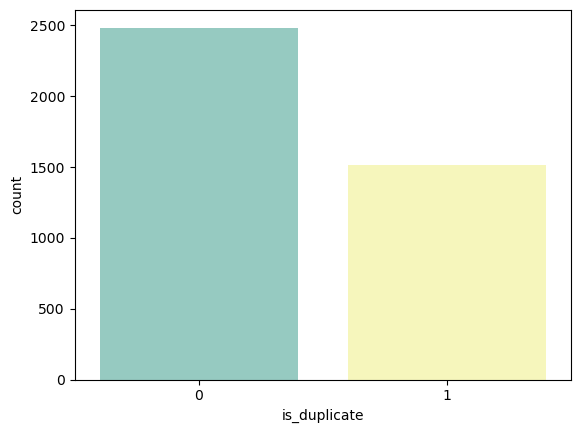

In [9]:
sns.countplot(x='is_duplicate', data=df , palette = "Set3")

In [10]:
# check for duplicated ids

duplicated_id = sum(df.duplicated('id'))
duplicated_qid1 = sum(df.duplicated('qid1'))
duplicated_qid2 = sum(df.duplicated('qid2'))

In [11]:
duplicated_id

0

In [12]:
duplicated_qid1

1

In [13]:
duplicated_qid2

0

In [14]:
# Let's look at the repeated questions in each columns.

# get the number question1 ids that appear more than once

q1 = df['qid1']
q1_duplicated = df[q1.isin(q1[q1.duplicated()])].shape[0]

In [15]:

q2 = df['qid2']
q2_duplicated = df[q2.isin(q2[q2.duplicated()])].shape[0]

In [16]:
q1_duplicated                   # repeated questions in questions 1

2

In [17]:
q2_duplicated                   # repeated questions in questions 2

0

In [18]:
# let's look at the questions corresponding to those ids

df_q1_duplicated = df[q1.isin(q1[q1.duplicated()])].sort_values('qid1')
df_q2_duplicated = df[q2.isin(q2[q2.duplicated()])].sort_values('qid2')

In [19]:
df_q1_duplicated

id  qid1  qid2                                         question1  \
660    660  1321  1322  What are the best available smartphones gadgets?   
3258  3258  1321  6515              What is the best Final Fantasy game?   

                                              question2  is_duplicate  
660   What are some of the best smartphones technolo...             1  
3258             What are the best Final Fantasy games?             1

In [20]:
df_q2_duplicated

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

# CHECKING FOR DUPLICATE QUESTIONS

In [21]:
ques1 = df['question1']
question1_duplicated =  df[ques1.isin(ques1[ques1.duplicated()])].shape[0]

In [22]:
question1_duplicated

48

In [23]:
df_ques1_duplicated = df[ques1.isin(ques1[ques1.duplicated()])].sort_values('question1')

In [24]:
df_ques1_duplicated

id  qid1  qid2                                          question1  \
2652  2652  5304  5305                 Can skipping increase your height?   
1761  1761  3523  3524                 Can skipping increase your height?   
1081  1081  2163  2164                        Did Trump win the election?   
934    934  1869  1870                        Did Trump win the election?   
351    351   703   704  Harvard College Courses: What is general shopp...   
3930  3930  7858  7859  Harvard College Courses: What is general shopp...   
365    365   731   732     How can I write a letter to Mr. Narendra Modi?   
3447  3447  6892  6893     How can I write a letter to Mr. Narendra Modi?   
877    877  1755  1756  How can changing 500 and 1000 rupee notes end ...   
1567  1567  3135  3136  How can changing 500 and 1000 rupee notes end ...   
3474  3474  6946  6947                           How do I get my ex back?   
803    803  1607  1608                           How do I get my ex back?   
2285  2285  4570  4571               How do I make money starting a blog?   
3634  3634  7266  7267               How do I make money starting a blog?   
2880  2880  5760  5761                              How do i lose weight?   
1806  1806  3613  3614                              How do i lose weight?   
1947  1947  3895  3896  I was suddenly logged off Gmail. I can't remem...   
58      58   117   118  I was suddenly logged off Gmail. I can't remem...   
3989  3989  7976  7977  If there will be a war between India and Pakis...   
287    287   575   576  If there will be a war between India and Pakis...   
2826  2826  5652  5653        Quora: How do you post a question on Quora?   
1108  1108  2217  2218        Quora: How do you post a question on Quora?   
2776  2776  5552  5553                 What are good ways to earn online?   
1321  1321  2643  2644                 What are good ways to earn online?   
2352  2352  4704  4705  What are the sensors available in Acer Liquid ...   
382    382   765   766  What are the sensors available in Acer Liquid ...   
2036  2036  4073  4074              What can I do to practice my English?   
2740  2740  5480  5481              What can I do to practice my English?   
2850  2850  5700  5701  What happens to a question on Quora if it is m...   
1471  1471  2943  2944  What happens to a question on Quora if it is m...   
3025  3025  6050  6051  What is your view on the recent demonetization...   
907    907  1815  1816  What is your view on the recent demonetization...   
1912  1912  3825  3826          What side dishes go well with hamburgers?   
1503  1503  3007  3008          What side dishes go well with hamburgers?   
991    991  1983  1984        What would be a cool way to commit suicide?   
3217  3217  6433  6434        What would be a cool way to commit suicide?   
1751  1751  3503  3504  Where can I get wonderful flavors on cupcakes ...   
1291  1291  2583  2584  Where can I get wonderful flavors on cupcakes ...   
110    110   221   222  Where can I watch gonulcelen with english subt...   
2655  2655  5310  5311  Where can I watch gonulcelen with english subt...   
1429  1429  2859  2860                 Which are the best movies of 2016?   
688    688  1377  1378                 Which are the best movies of 2016?   
264    264   529   530                                Why do Slavs squat?   
40      40    81    82                                Why do Slavs squat?   
1227  1227  2455  2456  Why do Trump supporters believe that Donald Tr...   
1467  1467  2935  2936  Why do Trump supporters believe that Donald Tr...   
3026  3026  6052  6053   Why do dogs wag their tails when they are happy?   
2987  2987  5974  5975   Why do dogs wag their tails when they are happy?   

                                              question2  is_duplicate  
2652                      How do I increase the height?             1  
1761  What is the best and fastest way to increase y...             1  
1081  What do you 

# DUPLICATED QUESTIONS

In [25]:
ques2 = df['question2']
question2_duplicated =  df[ques2.isin(ques2[ques2.duplicated()])].shape[0]

In [26]:
question2_duplicated

58

In [27]:
df_ques2_duplicated = df[ques2.isin(ques2[ques2.duplicated()])].sort_values('question2')

In [28]:
df_ques2_duplicated

id  qid1  qid2                                          question1  \
2549  2549  5098  5099              Is milk vegetarian or non vegetarian?   
1636  1636  3273  3274                        Are egg eaters vegetarians?   
3694  3694  7386  7387         How can I become a billionaire in mindset?   
318    318   637   638                    How can I become a billionaire?   
547    547  1095  1096          How can I hack someones whatsapp account?   
1114  1114  2229  2230                 How can I hack a WhatsApp account?   
1563  1563  3127  3128  What are the ways in which I can improve my ha...   
2228  2228  4456  4457                  How I can be good at handwriting?   
2235  2235  4470  4471                How did you learn to speak English?   
2740  2740  5480  5481              What can I do to practice my English?   
586    586  1173  1174              How do I stop being addicted to porn?   
3409  3409  6816  6817  How can I stop myself from watching too much o...   
3403  3403  6804  6805  How can I improve my communication skill and E...   
3958  3958  7914  7915              How can I speak English like natives?   
3477  3477  6952  6953            Which is the best way to control anger?   
656    656  1313  1314                     How can I control on my anger?   
1543  1543  3087  3088             How did Donald Trump become president?   
1983  1983  3967  3968                          How did Donald trump win?   
647    647  1295  1296                  How do I make money with YouTube?   
564    564  1129  1130                 How can I earn money from YouTube?   
2778  2778  5556  5557             How can I speak English more fluently?   
1499  1499  2999  3000             How can I be a native English speaker?   
296    296   593   594  How does concentric contractions differ from e...   
3724  3724  7446  7447  What are some symptoms of eccentric and concen...   
2674  2674  5348  5349  Can anyone increase their height at the age of...   
3299  3299  6596  6597  Is there any possibility to increase height af...   
1670  1670  3341  3342                         How does one fall in love?   
2251  2251  4502  4503                            How can I fall in love?   
1087  1087  2175  2176   How is the word 'anachronism' used in sentences?   
2249  2249  4498  4499       How is the word "jocund" used in a sentence?   
2063  2063  4127  4128      How can I get rid of cellulite on my stomach?   
3502  3502  7002  7003  I am a 15 year old girl and I have really heav...   
1332  1332  2665  2666                       Is a third world war coming?   
608    608  1217  1218                   Can World War 3 ever take place?   
2745  2745  5490  5491       Is coaching necessary for cracking the GATE?   
1972  1972  3945  3946  How do I prepare for the GATE and is coaching ...   
3606  3606  7210  7211  What kind of evidence has been found on Mars t...   
3834  3834  7666  7667                         Do invisible aliens exist?   
3991  3991  7980  7981   What are some best examples of Presence of mind?   
3983  3983  7964  7965      What are some examples of 'Presence of Mind'?   
1283  1283  2567  2568          Why do I not lose weight when I throw up?   
2290  2290  4580  4581      Is it possible to reduce 17 lbs in one month?   
637    637  1275  1276  Will the Supreme Court's decision of playing t...   
3159  3159  6318  6319  What do you think of Supreme Court's decision ...   
766    766  1533  1534           What are Mutual funds? How do they work?   
1426  1426  2853  2854                What is mutual funds with examples?   
2661  2661  5322  5323  Are public sector jobs and government jobs the...   
2400  2400  4800  4801  What is the difference between a public sector...   
3111  3111  6222  6223   How can we earn money online without investment?   
3075  3075  6150  6151               I'm 18. How can I make money online?   
326    326   653   654  What are the most interesting foods you have e...   
53  

In [29]:
same_questions = df[df['question1'] == df['question2']]

In [30]:
same_questions 

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

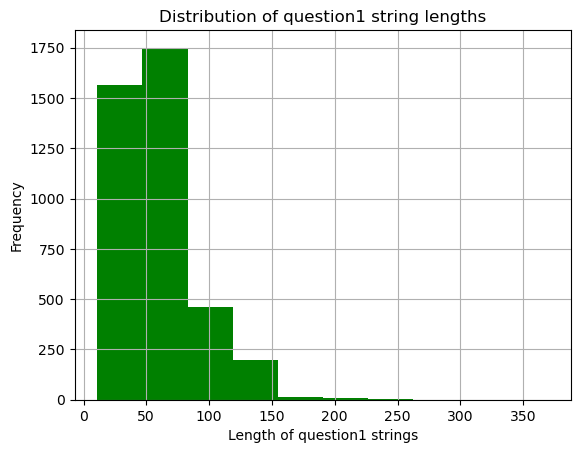

In [31]:


# plot histogram with color
df['question1'].str.len().hist(color='green')

# add labels and title
plt.xlabel('Length of question1 strings')
plt.ylabel('Frequency')
plt.title('Distribution of question1 string lengths')
plt.show()

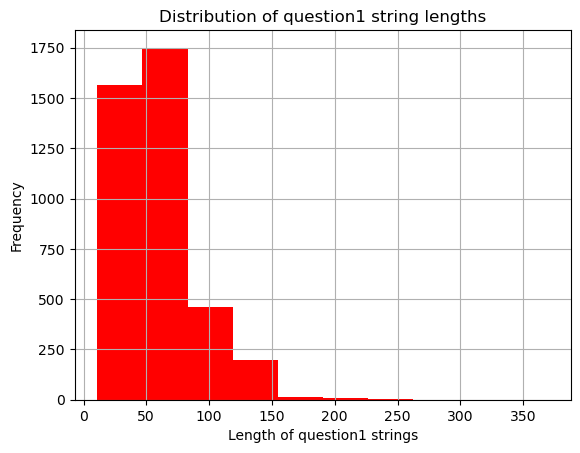

In [32]:
# plot histogram with color
df['question1'].str.len().hist(color='red')

# add labels and title
plt.xlabel('Length of question1 strings')
plt.ylabel('Frequency')
plt.title('Distribution of question1 string lengths')
plt.show()

# pre-trained spaCy model

In [33]:


nlp = spacy.load('en_core_web_sm')

# REMOVE STOPWORDS

In [34]:
questions_1 = df['question1']
questions_2 = df['question2']

In [35]:
# Remove stopwords
stop_words = set(stopwords.words('english'))

In [36]:
# define a function to remove stop words from text

def remove_stopwords(text):
    words = str(text).split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [37]:
# remove stop words from each question in the 'questions' list

questions_1_without_stopwords = [remove_stopwords(question) for question in questions_1]
questions_2_without_stopwords = [remove_stopwords(question) for question in questions_2]

# TOKENISATION

In [38]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)

def clean_data(text):
    doc = nlp(str(text))
    # tokenize
    # text = text.split()
    
    # Lemmatization
    text = [token.lemma_ for token in doc]
    
    # convert to lower case
    text = [word.lower() for word in text]
    
    # remove punctuation from each token
    text = [w.translate(table) for w in text]
    
    # Remove mentions and hashtags
    text = [re.sub(r'_@\w+|#\w+', ' ', text) for text in text]
    
    # remove hanging 's' and 'a'
    text = [word for word in text if len(word)>1]
    
    # remove tokens with numbers in them
    text = [word for word in text if word.isalpha()]
    
    # store as string
    return ' '.join(text)

In [39]:

df['question1_clean'] = [clean_data(x) for x in questions_1_without_stopwords]


In [40]:
df['question2_clean'] = [clean_data(x) for x in questions_2_without_stopwords]

In [41]:
df['question1_clean']

0               step step guide invest share market india
1                         story kohinoor koh noor diamond
2              increase speed internet connection use vpn
3                                mentally lonely solve it
4       one dissolve water quikly sugar salt methane c...
                              ...                        
3994                     package management trainee damco
3995        tv show movers shakers idea copy tonight show
3996                                       find hero life
3997                   difference nerd intelligent person
3998                                        learn english
Name: question1_clean, Length: 3999, dtype: object

In [42]:
df['question2_clean']

0                     step step guide invest share market
1       would happen indian government steal kohinoor ...
2                        internet speed increase hack dns
3                                   find remainder divide
4                           fish would survive salt water
                              ...                        
3994                     work management trainee bluestar
3995                   what be favorite scene tv show why
3996                                    proactive new job
3997                    difference curiosity intelligence
3998                                        learn english
Name: question2_clean, Length: 3999, dtype: object

# FINDING NUMBER OF COMMON WORDS IN BOTH QUESTIONS 1& 2

In [43]:
tokens1 = df['question1_clean']
tokens2 = df['question2_clean']

In [44]:
words1 = set([word.lower() for sentence in tokens1 for word in sentence.split()])
words2 = set([word.lower() for sentence in tokens2 for word in sentence.split()])

In [45]:
len(words1) , len(words2)

(5809, 5571)

In [46]:

# Find common words
common_words = words1.intersection(words2)

In [47]:
word_counts = Counter()
for sentence in tokens1 + tokens2:
    for word in sentence.split():
        if word.lower() in common_words:
            word_counts[word.lower()] += 1

In [48]:
len(word_counts)

3930

In [49]:
word_counts.most_common()

[('good', 557),
 ('get', 346),
 ('use', 229),
 ('like', 213),
 ('india', 202),
 ('be', 197),
 ('people', 195),
 ('way', 192),
 ('make', 188),
 ('one', 176),
 ('would', 174),
 ('learn', 156),
 ('work', 128),
 ('year', 127),
 ('question', 126),
 ('time', 124),
 ('life', 120),
 ('quora', 118),
 ('well', 114),
 ('money', 111),
 ('new', 111),
 ('know', 109),
 ('think', 108),
 ('go', 108),
 ('job', 105),
 ('difference', 103),
 ('trump', 102),
 ('not', 100),
 ('start', 100),
 ('someone', 99),
 ('take', 98),
 ('thing', 97),
 ('become', 94),
 ('indian', 92),
 ('find', 91),
 ('ever', 91),
 ('without', 90),
 ('first', 88),
 ('mean', 87),
 ('girl', 87),
 ('day', 87),
 ('world', 86),
 ('want', 83),
 ('much', 83),
 ('book', 83),
 ('phone', 82),
 ('us', 78),
 ('need', 77),
 ('happen', 75),
 ('compare', 73),
 ('movie', 72),
 ('change', 71),
 ('ask', 70),
 ('old', 70),
 ('company', 69),
 ('online', 69),
 ('account', 68),
 ('note', 67),
 ('lose', 66),
 ('love', 66),
 ('what', 65),
 ('many', 65),
 ('see'

In [50]:
type(word_counts)

collections.Counter

In [51]:
# Get the list of words and their counts
word_list = [(word, count) for word, count in word_counts.most_common()]

In [52]:
# Extract the words from the list of tuples
words_only = [word for word, count in word_list]

In [53]:
words_only

['good',
 'get',
 'use',
 'like',
 'india',
 'be',
 'people',
 'way',
 'make',
 'one',
 'would',
 'learn',
 'work',
 'year',
 'question',
 'time',
 'life',
 'quora',
 'well',
 'money',
 'new',
 'know',
 'think',
 'go',
 'job',
 'difference',
 'trump',
 'not',
 'start',
 'someone',
 'take',
 'thing',
 'become',
 'indian',
 'find',
 'ever',
 'without',
 'first',
 'mean',
 'girl',
 'day',
 'world',
 'want',
 'much',
 'book',
 'phone',
 'us',
 'need',
 'happen',
 'compare',
 'movie',
 'change',
 'ask',
 'old',
 'company',
 'online',
 'account',
 'note',
 'lose',
 'love',
 'what',
 'many',
 'see',
 'war',
 'do',
 'country',
 'say',
 'number',
 'give',
 'feel',
 'student',
 'answer',
 'english',
 'live',
 'buy',
 'friend',
 'still',
 'engineering',
 'look',
 'stop',
 'black',
 'language',
 'really',
 'different',
 'come',
 'weight',
 'app',
 'card',
 'could',
 'donald',
 'programming',
 'person',
 'guy',
 'cause',
 'long',
 'month',
 'computer',
 'help',
 'email',
 'woman',
 'school',
 'stud

In [54]:
vocabulary = words_only

In [55]:
# Save the variable as a .npy file

np.save('vocabulary.npy', vocabulary)

# TOTAL WORDS COUNT IN EACH QUESTIONS COLUMN

In [56]:
from collections import Counter
words = [sentence.split() for sentence in tokens1]

word_counts_question1 = Counter()
for sentence in words:
    for word in sentence:
        word_counts_question1[word] += 1

In [57]:
word_counts_question1.most_common()

[('good', 425),
 ('get', 211),
 ('india', 147),
 ('use', 127),
 ('like', 122),
 ('make', 116),
 ('people', 116),
 ('one', 114),
 ('be', 107),
 ('would', 103),
 ('way', 102),
 ('learn', 92),
 ('difference', 90),
 ('quora', 82),
 ('life', 80),
 ('time', 72),
 ('think', 71),
 ('well', 68),
 ('know', 68),
 ('question', 67),
 ('year', 67),
 ('find', 66),
 ('work', 66),
 ('mean', 65),
 ('much', 62),
 ('new', 61),
 ('not', 61),
 ('what', 60),
 ('start', 60),
 ('day', 58),
 ('trump', 57),
 ('job', 57),
 ('ever', 57),
 ('do', 57),
 ('someone', 56),
 ('world', 56),
 ('go', 55),
 ('take', 54),
 ('money', 53),
 ('many', 52),
 ('thing', 52),
 ('become', 52),
 ('girl', 48),
 ('without', 48),
 ('indian', 48),
 ('movie', 48),
 ('happen', 48),
 ('first', 46),
 ('change', 45),
 ('book', 45),
 ('phone', 45),
 ('company', 44),
 ('want', 44),
 ('stop', 44),
 ('account', 43),
 ('need', 43),
 ('online', 42),
 ('note', 42),
 ('lose', 40),
 ('app', 40),
 ('us', 39),
 ('number', 39),
 ('could', 39),
 ('feel', 3

In [58]:
len(word_counts_question1)

5809

In [59]:
from collections import Counter
words1 = [sentence.split() for sentence in tokens2]

word_counts_question2 = Counter()
for sentence in words1:
    for word in sentence:
        word_counts_question2[word] += 1

In [60]:
word_counts_question2.most_common()

[('good', 456),
 ('get', 246),
 ('india', 152),
 ('would', 131),
 ('people', 131),
 ('use', 129),
 ('like', 128),
 ('be', 121),
 ('make', 118),
 ('way', 113),
 ('one', 103),
 ('learn', 97),
 ('life', 91),
 ('quora', 85),
 ('work', 85),
 ('well', 83),
 ('year', 83),
 ('think', 81),
 ('time', 78),
 ('question', 75),
 ('know', 73),
 ('what', 69),
 ('difference', 68),
 ('money', 67),
 ('find', 64),
 ('much', 64),
 ('go', 63),
 ('mean', 61),
 ('start', 61),
 ('job', 60),
 ('become', 60),
 ('want', 60),
 ('thing', 58),
 ('trump', 57),
 ('book', 57),
 ('someone', 56),
 ('many', 56),
 ('new', 56),
 ('us', 55),
 ('not', 55),
 ('phone', 54),
 ('first', 54),
 ('girl', 54),
 ('take', 54),
 ('world', 54),
 ('indian', 52),
 ('happen', 51),
 ('ever', 51),
 ('day', 50),
 ('need', 50),
 ('movie', 48),
 ('online', 46),
 ('do', 46),
 ('love', 45),
 ('company', 44),
 ('feel', 43),
 ('ask', 43),
 ('country', 42),
 ('without', 42),
 ('say', 40),
 ('account', 40),
 ('donald', 40),
 ('see', 39),
 ('war', 39),

In [61]:
len(word_counts_question2)

5571

# IDENTIFYING SAME QUESTIONS IN QUESTIONS 1 & 2

In [62]:
same_questions = df[df['question1_clean'] == df['question2_clean']]

In [63]:
same_questions

id  qid1  qid2                                          question1  \
12      12    25    26               What can make Physics easy to learn?   
16      16    33    34                       What does manipulation mean?   
22      22    45    46    What are the questions should not ask on Quora?   
41      41    83    84  When can I expect my Cognizant confirmation mail?   
42      42    85    86          Can I make 50,000 a month by day trading?   
...    ...   ...   ...                                                ...   
3966  3966  7930  7931                 When will we run out of resources?   
3969  3969  7936  7937  What is potential differential and why is it i...   
3979  3979  7956  7957               Which laptop should I buy under 60k?   
3983  3983  7964  7965      What are some examples of 'Presence of Mind'?   
3998  3998  7994  7995                             How can learn English?   

                                              question2  is_duplicate  \
12              How can you make physics easy to learn?             1   
16                        What does manipulation means?             1   
22                Which question should I ask on Quora?             0   
41       When can I expect Cognizant confirmation mail?             0   
42            Can I make 30,000 a month by day trading?             0   
...                                                 ...           ...   
3966                       Can we run out of resources?             0   
3969           Why is potential differential important?             1   
3979             Which laptop should I buy under 60000?             0   
3983  What are some of the examples of presence of m...             1   
3998                   How can I learn English wellï¼Ÿ?             1   

                         question1_clean                     question2_clean  
12               make physics easy learn             make physics easy learn  
16                     manipulation mean                   manipulation mean  
22                    question ask quora                  question ask quora  
41    expect cognizant confirmation mail  expect cognizant confirmation mail  
42                make month day trading              make month day trading  
...                                  ...                                 ...  
3966                        run resource                        run resource  
3969    potential differential important    potential differential important  
3979                          laptop buy                          laptop buy  
3983               example presence mind               example presence mind  
3998                       learn english                       learn english  

[259 rows x 8 columns]

# CREATING EMBEDDINGS

In [64]:
def create_embeddings(inputs):
    # Preprocess inputs by splitting them into lists of words
    tokenized_inputs = [input_str.split() for input_str in inputs]
    
    # Train Word2Vec model on input sentences
    model = Word2Vec(tokenized_inputs, min_count=1)
    
    # Extract word embeddings from trained model
    embeddings = [model.wv[word] for sentence in tokenized_inputs for word in sentence]
    
    return embeddings

In [65]:
type(tokens1)

pandas.core.series.Series

In [66]:
tokens1_list = list((tokens1).values)
tokens2_list = list((tokens2).values)

In [67]:
embeddings1 = create_embeddings(tokens1_list)
embeddings2 = create_embeddings(tokens2_list)

In [68]:
len(embeddings1)

21871

In [69]:
len(embeddings2)

22168

In [70]:
type(embeddings1)

list

In [71]:
embeddings1[0]

array([-0.00684466, -0.0056436 , -0.00834487,  0.0096906 ,  0.00175719,
       -0.00430889,  0.00709307, -0.0014601 ,  0.00245968,  0.00441082,
        0.00609277,  0.0058643 , -0.00265855, -0.00311495,  0.00099757,
        0.0012082 , -0.00579876,  0.00333889,  0.00666962,  0.00440578,
        0.00150082,  0.0048586 ,  0.00758771,  0.00382807, -0.00325061,
        0.00733674,  0.00393285,  0.00364642, -0.00920573, -0.0019049 ,
        0.00390488,  0.00526781, -0.00370193, -0.0086568 ,  0.00894943,
       -0.00491048, -0.009399  , -0.00988579, -0.00300783,  0.00118441,
        0.00463561,  0.00849877, -0.00548648, -0.01016177,  0.00773307,
       -0.00769612, -0.00773397,  0.00582435,  0.00656878, -0.0048184 ,
        0.00723237, -0.00870913,  0.00313422,  0.00144841, -0.0107451 ,
       -0.00111747, -0.00807889, -0.00733338,  0.0051603 , -0.00514859,
       -0.0052583 , -0.00842203, -0.00853323,  0.00859159, -0.01198295,
       -0.00225077, -0.00080466,  0.01090467, -0.00980062,  0.00

# CREATING VECTORS USING TF-IDF

In [72]:
# Initialize the vectorizer with TF-IDF method
vectorizer = TfidfVectorizer()


In [73]:
# Fit and transform the sentences

vectorized_sentences1 = vectorizer.fit_transform(tokens1).toarray()

vectorized_sentences2 = vectorizer.transform(tokens2).toarray()

In [74]:
vectorized_sentences1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [75]:

vectorized_sentences2


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
len(vectorized_sentences1)

3999

In [77]:
len(vectorized_sentences2)

3999

In [78]:
type(vectorized_sentences1)

numpy.ndarray

In [79]:
# save the variable in .npy format
np.save('embedding_matrix1.npy', vectorized_sentences1)
np.save('embedding_matrix2.npy', vectorized_sentences2)

# NEW DATAFRAME WITH WORD FEATURES

In [86]:
df['question1_len'] = df['question1_len'].str.len() 
df['question2_len'] = df['question2_len'].str.len()

In [87]:
df['question1_len'] = df['question1_len'].astype(int)

In [88]:

print('minimum characters', df['question1_len'].min())
print('maximum characters', df['question1_len'].max())


minimum characters 0
maximum characters 257


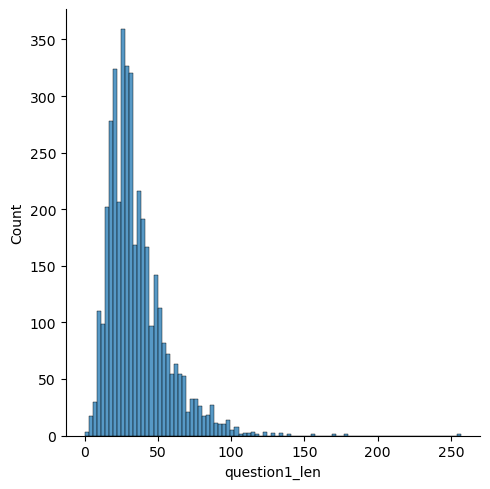

In [89]:
# Analysis of features
sns.displot(df['question1_len'])


In [90]:

print('minimum characters', df['question2_len'].min())
print('maximum characters', df['question2_len'].max())

minimum characters 2
maximum characters 196


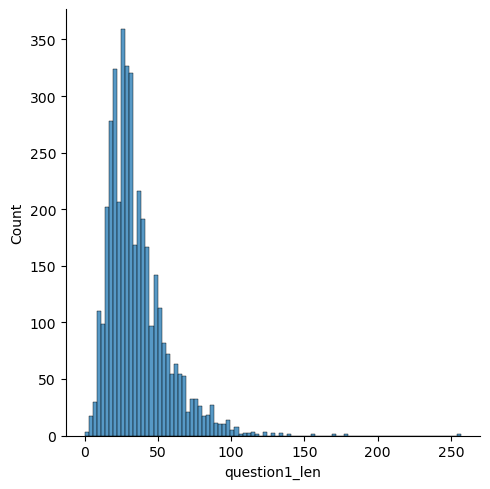

In [91]:
sns.displot(df['question1_len'])

In [92]:
df = df.drop(columns= ['question1', 'question2'])

In [93]:
df

id  qid1  qid2  is_duplicate  \
0        0     1     2             0   
1        1     3     4             0   
2        2     5     6             0   
3        3     7     8             0   
4        4     9    10             0   
...    ...   ...   ...           ...   
3994  3994  7986  7987             0   
3995  3995  7988  7989             0   
3996  3996  7990  7991             0   
3997  3997  7992  7993             0   
3998  3998  7994  7995             1   

                                        question1_clean  \
0             step step guide invest share market india   
1                       story kohinoor koh noor diamond   
2            increase speed internet connection use vpn   
3                              mentally lonely solve it   
4     one dissolve water quikly sugar salt methane c...   
...                                                 ...   
3994                   package management trainee damco   
3995      tv show movers shakers idea copy tonight show   
3996                                     find hero life   
3997                 difference nerd intelligent person   
3998                                      learn english   

                                        question2_clean  question1_len  \
0                   step step guide invest share market             41   
1     would happen indian government steal kohinoor ...             31   
2                      internet speed increase hack dns             42   
3                                 find remainder divide             24   
4                         fish would survive salt water             60   
...                                                 ...            ...   
3994                   work management trainee bluestar             32   
3995                 what be favorite scene tv show why             45   
3996                                  proactive new job             14   
3997                  difference curiosity intelligence             34   
3998                                      learn english             13   

      question2_len  
0                35  
1                67  
2                32  
3                21  
4                29  
...             ...  
3994             32  
3995             34  
3996             17  
3997             33  
3998             13  

[3999 rows x 8 columns]

C:\Users\Ashok\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


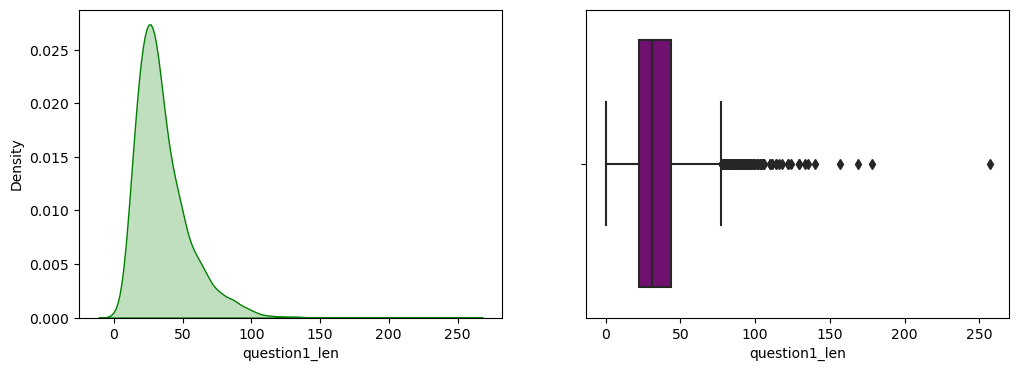

In [94]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(df['question1_len'],color='g',shade=True)
plt.subplot(1,2,2)
sns.boxplot(df['question1_len'], color='purple')
plt.show()

C:\Users\Ashok\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


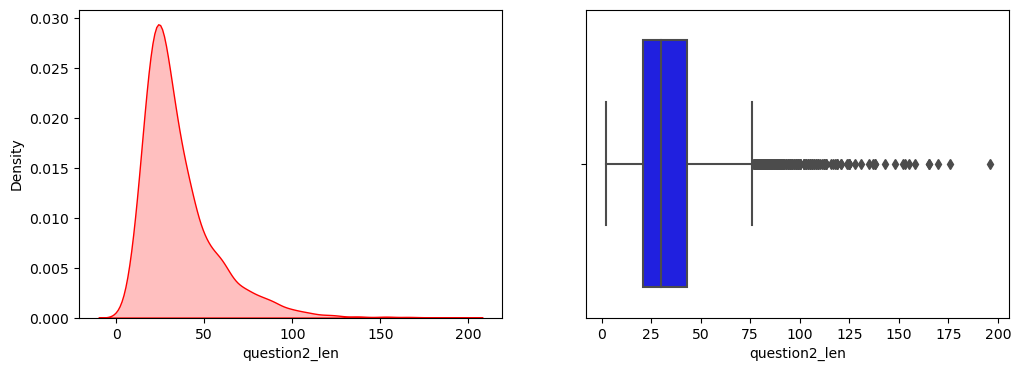

In [95]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(df['question2_len'],color='r',shade=True)
plt.subplot(1,2,2)
sns.boxplot(df['question2_len'], color='blue')
plt.show()

In [96]:
#Number of Unique Questions

qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

In [97]:
unique_qids = len(np.unique(qids))

print ('Total number of  Unique Questions are:',unique_qids)

Total number of  Unique Questions are: 7995


In [98]:
repeated = np.sum(qids.value_counts() > 1)

print ('Number of unique questions that appear more than one time:', repeated)

Number of unique questions that appear more than one time: 3


In [99]:

print ('Max number of times a single question is repeated:',max(qids.value_counts()))


Max number of times a single question is repeated: 2


C:\Users\Ashok\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


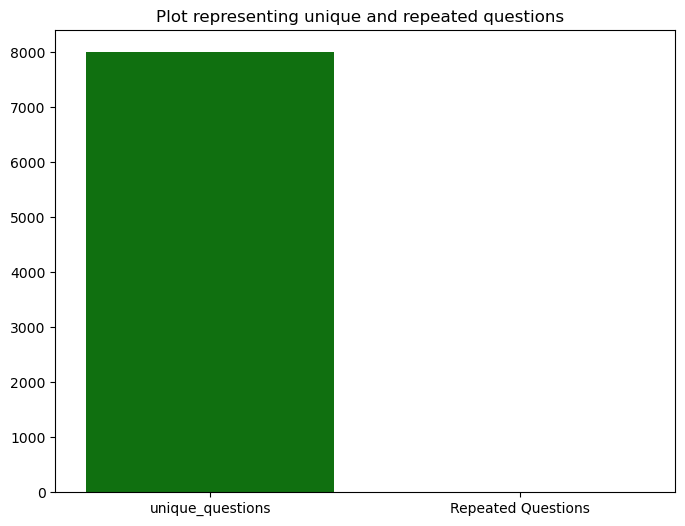

In [100]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qids , repeated]

plt.figure(figsize=(8, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y, color='green')
plt.show()


In [101]:
df['common_words'] = df.apply(lambda x: len(set(str(x['question1_clean']).lower().split()).intersection(set(str(x['question2_clean']).lower().split()))), axis=1)

# COSINE_SIMILARITY

In [102]:

def cosine_similarity(x, y):
    dot_product = np.dot(x, y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    return dot_product / (norm_x * norm_y)


In [103]:
df['cosine_distance'] = [cosine_similarity(x, y) for (x, y) in zip(vectorized_sentences1,vectorized_sentences2)]

C:\Users\Ashok\AppData\Local\Temp\ipykernel_30800\3586094777.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return dot_product / (norm_x * norm_y)


# EUCLIDEAN_DISTANCE

In [104]:

def euclidean_distance(x, y):
    return np.sqrt(np.sum(np.square(x - y)))

In [105]:
euclidean_distances = []

for x, y in zip(vectorized_sentences1, vectorized_sentences2):
    distance = euclidean_distance(np.nan_to_num(x), np.nan_to_num(y))
    euclidean_distances.append(distance)

In [106]:
df['euclidean_distances'] = euclidean_distances

# MINKOWSKI DISTANCE

In [107]:

def minkowski_distance(x, y, p):
    return np.power(np.sum(np.power(np.abs(x - y), p)), 1/p)

In [108]:
minkowski_distances = []

for x, y in zip(vectorized_sentences1,vectorized_sentences2):
    distance = minkowski_distance(np.nan_to_num(x), np.nan_to_num(y), 3)  # p=3
    minkowski_distances.append(distance)

In [109]:
df['minkowski_distances'] = minkowski_distances

# MANHATTAN DISTANCE

In [110]:
def manhattan_distance(x, y):
    return np.sum(np.abs(x - y))

In [111]:
manhattan_distances = []

for x, y in zip(vectorized_sentences1, vectorized_sentences2):
    distance = manhattan_distance(np.nan_to_num(x), np.nan_to_num(y))
    manhattan_distances.append(distance)

In [112]:
df['manhattan_distances']  = manhattan_distances

# JACCARD DISTANCES

In [113]:
def jaccard_distance(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return 1.0 - (intersection_cardinality / float(union_cardinality))

In [114]:
jaccard_distances = []

for x, y in zip(vectorized_sentences1, vectorized_sentences2):
    distance = jaccard_distance(np.nan_to_num(x), np.nan_to_num(y))
    jaccard_distances.append(distance)

In [115]:
df['jaccard_distances']  = jaccard_distances

# FUZZY MATCHING

Fuzzy matching is a technique used to match strings that are not exact matches.  
Fuzzy matching algorithms attempt to find the best match between two strings by comparing them based on various criteria, 
such as the number of shared characters, the number of shared words, or the similarity of their phonetic or semantic representations.

One popular library in Python for fuzzy matching is fuzzywuzzy.

     fuzz.ratio(): compares two strings based on the ratio of their shared characters to their total characters.
     fuzz.partial_ratio(): compares two strings based on the ratio of their shared characters to the length of the shorter string.
     fuzz.token_sort_ratio(): compares two strings based on the ratio of their shared words, after sorting the words in each string alphabetically.
     fuzz.token_set_ratio(): compares two strings based on the ratio of their shared words, after removing any duplicates.


In [116]:
def calc_fuzzy_metrics(row):
    q1 = str(row['question1_clean'])
    q2 = str(row['question2_clean'])
    
    fuzz_ratio = fuzz.ratio(q1, q2)
    fuzz_partial_ratio = fuzz.partial_ratio(q1, q2)
    fuzz_token_set_ratio = fuzz.token_set_ratio(q1, q2)
    fuzz_token_sort_ratio = fuzz.token_sort_ratio(q1, q2)
    
    return (fuzz_ratio, fuzz_partial_ratio, fuzz_token_set_ratio, fuzz_token_sort_ratio)

In [117]:

df[['fuzz_ratio', 'fuzz_partial_ratio', 'fuzz_token_set_ratio', 'fuzz_token_sort_ratio']] = df.apply(calc_fuzzy_metrics, axis=1, result_type='expand')

In [118]:
df

id  qid1  qid2  is_duplicate  \
0        0     1     2             0   
1        1     3     4             0   
2        2     5     6             0   
3        3     7     8             0   
4        4     9    10             0   
...    ...   ...   ...           ...   
3994  3994  7986  7987             0   
3995  3995  7988  7989             0   
3996  3996  7990  7991             0   
3997  3997  7992  7993             0   
3998  3998  7994  7995             1   

                                        question1_clean  \
0             step step guide invest share market india   
1                       story kohinoor koh noor diamond   
2            increase speed internet connection use vpn   
3                              mentally lonely solve it   
4     one dissolve water quikly sugar salt methane c...   
...                                                 ...   
3994                   package management trainee damco   
3995      tv show movers shakers idea copy tonight show   
3996                                     find hero life   
3997                 difference nerd intelligent person   
3998                                      learn english   

                                        question2_clean  question1_len  \
0                   step step guide invest share market             41   
1     would happen indian government steal kohinoor ...             31   
2                      internet speed increase hack dns             42   
3                                 find remainder divide             24   
4                         fish would survive salt water             60   
...                                                 ...            ...   
3994                   work management trainee bluestar             32   
3995                 what be favorite scene tv show why             45   
3996                                  proactive new job             14   
3997                  difference curiosity intelligence             34   
3998                                      learn english             13   

      question2_len  common_words  cosine_distance  euclidean_distances  \
0                35             5         0.977118             0.213924   
1                67             4         0.708126             0.764034   
2                32             3         0.599502             0.894983   
3                21             0         0.000000             1.414214   
4                29             2         0.249909             1.224819   
...             ...           ...              ...                  ...   
3994             32             2         0.604812             0.889031   
3995             34             2         0.306822             1.177436   
3996             17             0         0.000000             1.414214   
3997             33             1         0.190946             1.272049   
3998             13             2         1.000000             0.000000   

      minkowski_distances  manhattan_distances  jaccard_distances  fuzz_ratio  \
0                0.212742             0.261590           0.916667          92   
1                0.550300             2.283288           0.900000          57   
2                0.708720             2.040962           0.909091          27   
3                1.086520             3.351458           0.857143          18   
4                0.838590             4.164808           0.909091          25   
...                   ...                  ...                ...         ...   
3994             0.722682             1.812016           0.857143          69   
3995             0.805822             3.889226           0.923077          25   
3996             1.101967             3.095291           0.833333          26   
3997             1.026242             2.646534           0.857143          72   
3998             0.000000             0.000000           0.000000         100   

      fuzz_partial_ratio  fuzz_token_set_ratio  fuzz_to

# SAVING DATAFRAME IN CSV FORM

In [119]:
similarity_df = df.copy()

In [120]:
similarity_df.to_csv('similarity.csv', index = False)

# CREATING NEW DATAFRAME AS COPY OF DF

In [121]:
final_df = df.copy()

In [122]:
final_df = final_df.drop(columns= ['qid1', 'qid2', 'id', 'question1_clean', 'question2_clean'])

In [123]:
final_df

is_duplicate  question1_len  question2_len  common_words  \
0                0             41             35             5   
1                0             31             67             4   
2                0             42             32             3   
3                0             24             21             0   
4                0             60             29             2   
...            ...            ...            ...           ...   
3994             0             32             32             2   
3995             0             45             34             2   
3996             0             14             17             0   
3997             0             34             33             1   
3998             1             13             13             2   

      cosine_distance  euclidean_distances  minkowski_distances  \
0            0.977118             0.213924             0.212742   
1            0.708126             0.764034             0.550300   
2            0.599502             0.894983             0.708720   
3            0.000000             1.414214             1.086520   
4            0.249909             1.224819             0.838590   
...               ...                  ...                  ...   
3994         0.604812             0.889031             0.722682   
3995         0.306822             1.177436             0.805822   
3996         0.000000             1.414214             1.101967   
3997         0.190946             1.272049             1.026242   
3998         1.000000             0.000000             0.000000   

      manhattan_distances  jaccard_distances  fuzz_ratio  fuzz_partial_ratio  \
0                0.261590           0.916667          92                 100   
1                2.283288           0.900000          57                  90   
2                2.040962           0.909091          27                  51   
3                3.351458           0.857143          18                   8   
4                4.164808           0.909091          25                  52   
...                   ...                ...         ...                 ...   
3994             1.812016           0.857143          69                  71   
3995             3.889226           0.923077          25                  39   
3996             3.095291           0.833333          26                  29   
3997             2.646534           0.857143          72                  73   
3998             0.000000           0.000000         100                 100   

      fuzz_token_set_ratio  fuzz_token_sort_ratio  
0                      100                     92  
1                       89                     59  
2                       84                     68  
3                       27                     27  
4                       51                     40  
...                    ...                    ...  
3994                    72                     62  
3995                    46                     41  
3996                    39                     39  
3997                    66                     66  
3998                   100                    100  

[3999 rows x 13 columns]

In [124]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   is_duplicate           3999 non-null   int64  
 1   question1_len          3999 non-null   int32  
 2   question2_len          3999 non-null   int64  
 3   common_words           3999 non-null   int64  
 4   cosine_distance        3983 non-null   float64
 5   euclidean_distances    3999 non-null   float64
 6   minkowski_distances    3999 non-null   float64
 7   manhattan_distances    3999 non-null   float64
 8   jaccard_distances      3999 non-null   float64
 9   fuzz_ratio             3999 non-null   int64  
 10  fuzz_partial_ratio     3999 non-null   int64  
 11  fuzz_token_set_ratio   3999 non-null   int64  
 12  fuzz_token_sort_ratio  3999 non-null   int64  
dtypes: float64(5), int32(1), int64(7)
memory usage: 390.7 KB


In [125]:
# Find the minimum value in each column
min_values = final_df.min(axis=0)

# Find the maximum value in each column
max_values = final_df.max(axis=0)

In [126]:

print("Minimum similarity:\n", min_values)

Minimum similarity:
 is_duplicate             0.0
question1_len            0.0
question2_len            2.0
common_words             0.0
cosine_distance          0.0
euclidean_distances      0.0
minkowski_distances      0.0
manhattan_distances      0.0
jaccard_distances        0.0
fuzz_ratio               0.0
fuzz_partial_ratio       0.0
fuzz_token_set_ratio     0.0
fuzz_token_sort_ratio    0.0
dtype: float64


In [127]:
print("Minimum similarity:\n", max_values)

Minimum similarity:
 is_duplicate               1.000000
question1_len            257.000000
question2_len            196.000000
common_words              13.000000
cosine_distance            1.000000
euclidean_distances        1.414214
minkowski_distances        1.259921
manhattan_distances        7.401956
jaccard_distances          0.970588
fuzz_ratio               100.000000
fuzz_partial_ratio       100.000000
fuzz_token_set_ratio     100.000000
fuzz_token_sort_ratio    100.000000
dtype: float64


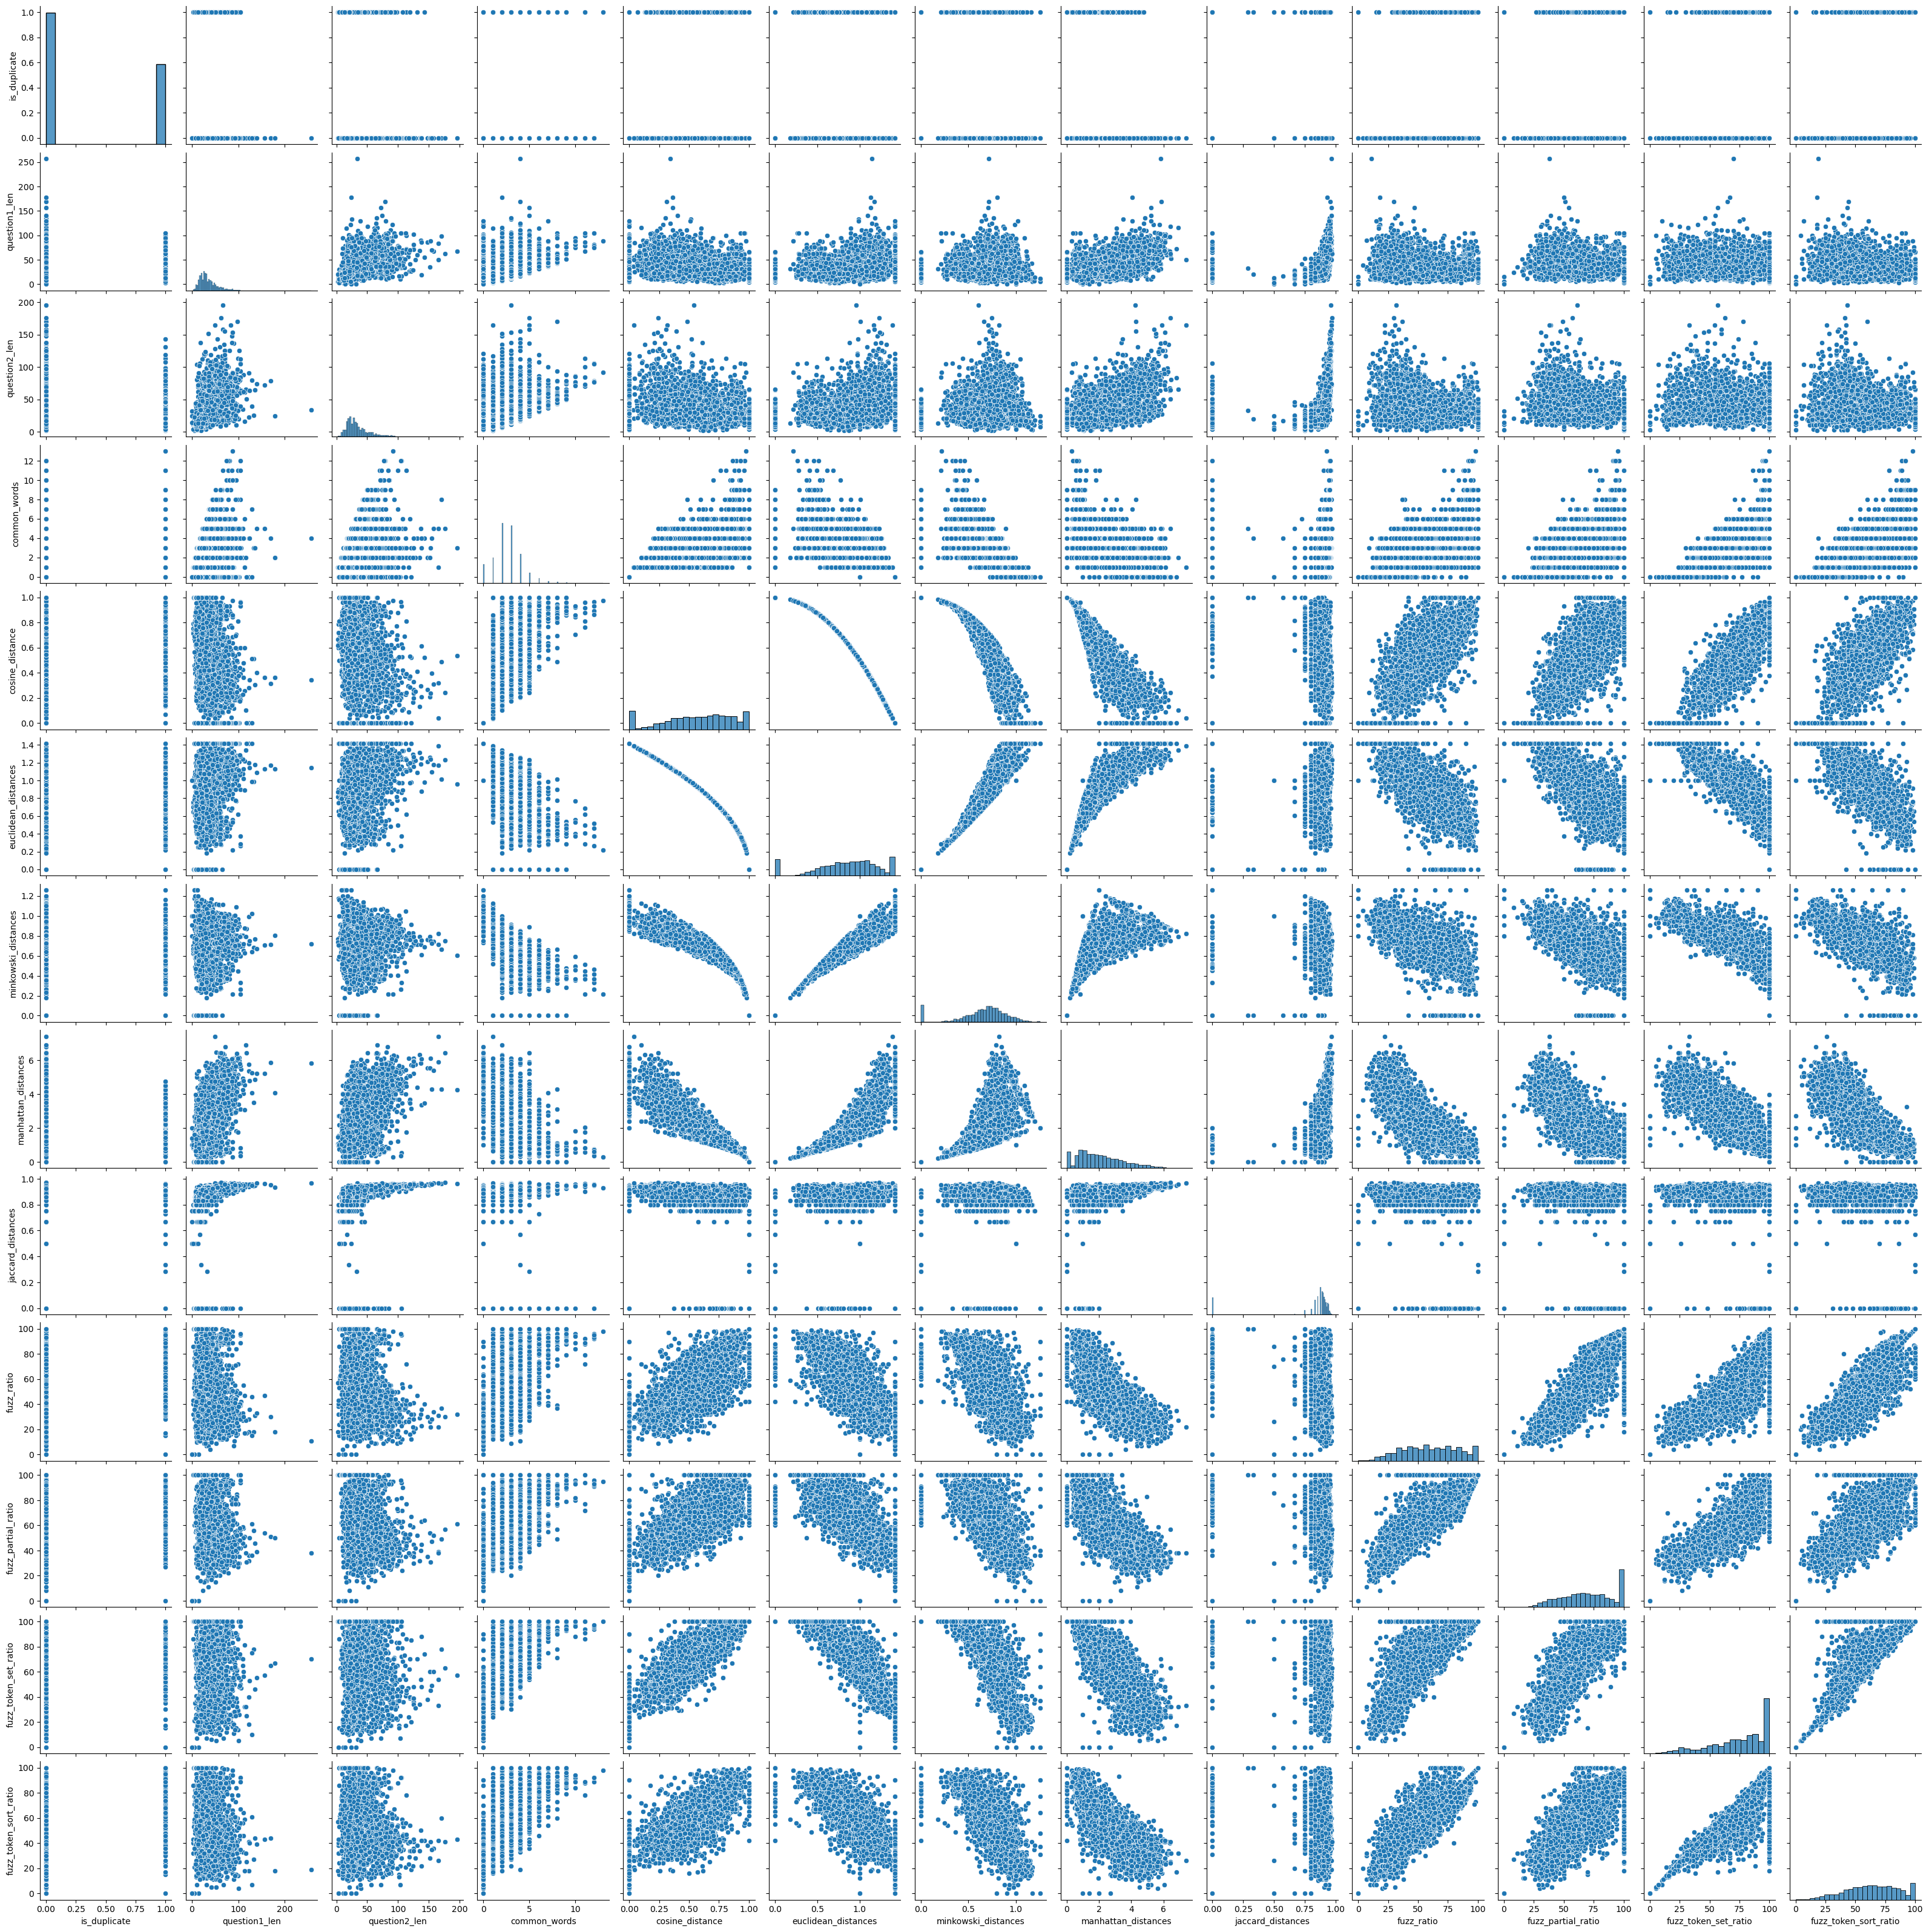

In [128]:
sns.pairplot(final_df)

<AxesSubplot:xlabel='cosine_distance', ylabel='Density'>

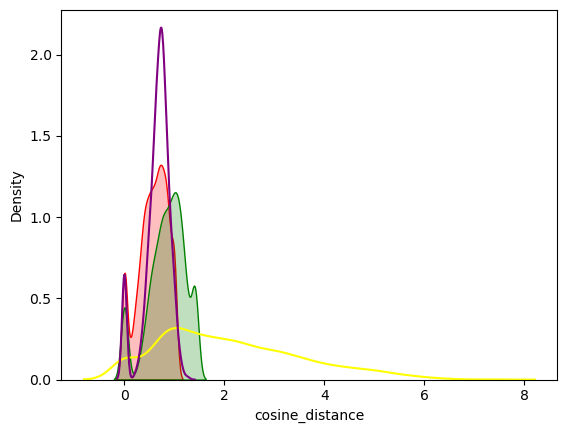

In [129]:
fig, ax = plt.subplots()
sns.kdeplot(data=final_df['cosine_distance'], ax=ax, color='red', fill=True)
sns.kdeplot(data=final_df['euclidean_distances'], ax=ax, color='green', fill=True)
sns.kdeplot(data=final_df['manhattan_distances'], ax=ax, color='yellow')
sns.kdeplot(data=final_df['minkowski_distances'], ax=ax, color='purple')




<AxesSubplot:xlabel='fuzz_ratio', ylabel='Density'>

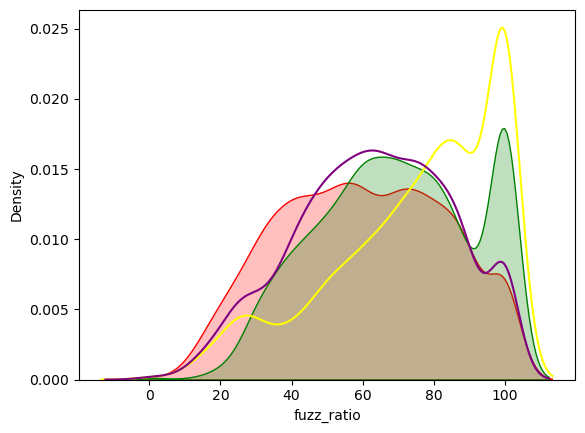

In [130]:
fig, ax = plt.subplots()
sns.kdeplot(data=final_df['fuzz_ratio'], ax=ax, color='red', fill=True)
sns.kdeplot(data=final_df['fuzz_partial_ratio'], ax=ax, color='green', fill=True)
sns.kdeplot(data=final_df['fuzz_token_set_ratio'], ax=ax, color='yellow')
sns.kdeplot(data=final_df['fuzz_token_sort_ratio'], ax=ax, color='purple')

<AxesSubplot:>

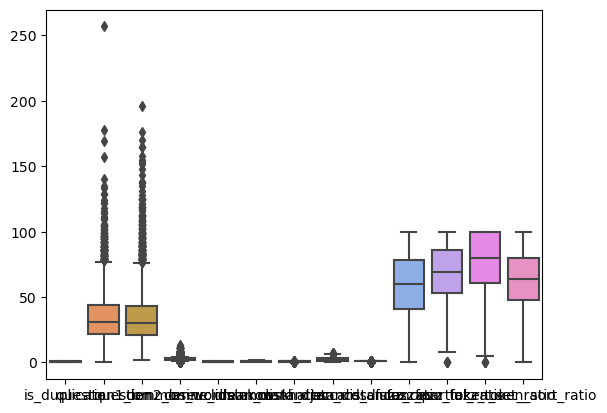

In [131]:
sns.boxplot(data=final_df)

<Figure size 2000x1500 with 0 Axes>

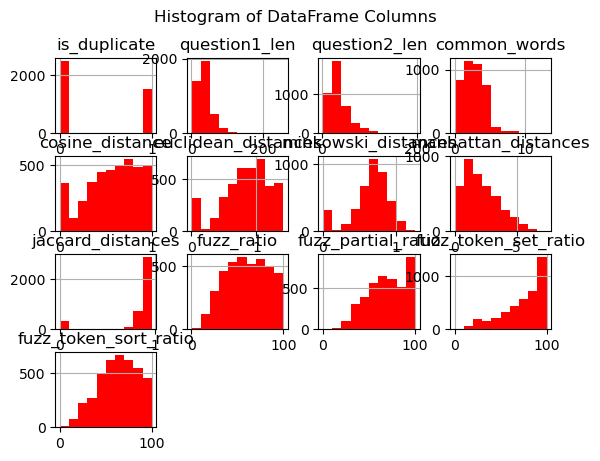

In [157]:
plt.figure(figsize=(20,15))
# plot histogram for all columns with different colors
final_df.hist(color=['red'])

# add labels and title
plt.suptitle('Histogram of DataFrame Columns')
plt.show()

<AxesSubplot:xlabel='cosine_distance', ylabel='Density'>

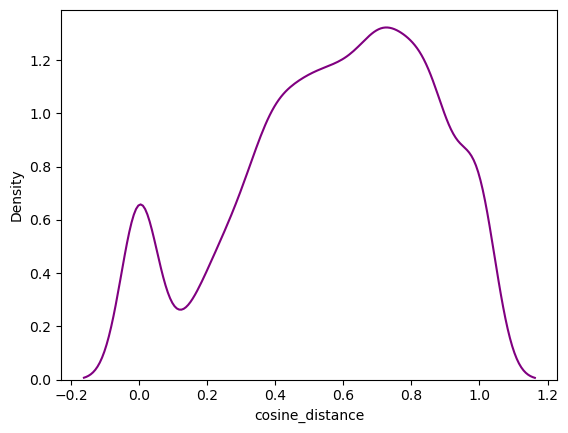

In [133]:
sns.kdeplot(final_df['cosine_distance'], color = 'purple')

<AxesSubplot:title={'center':'MINKOWSKI DISTANCE SIMILARITIES'}, ylabel='Frequency'>

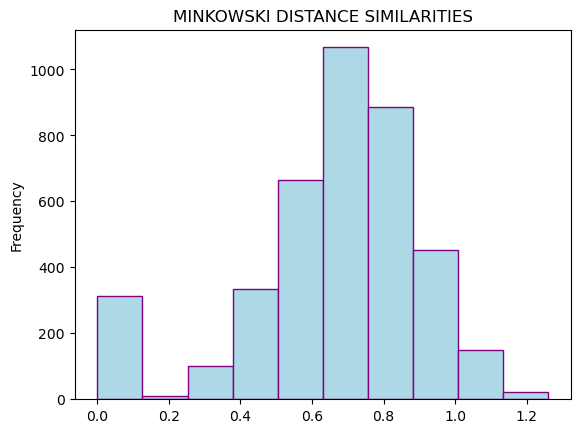

In [134]:
final_df['minkowski_distances'].plot(kind = 'hist',color='lightblue', 
                                     edgecolor='purple' , title='MINKOWSKI DISTANCE SIMILARITIES')

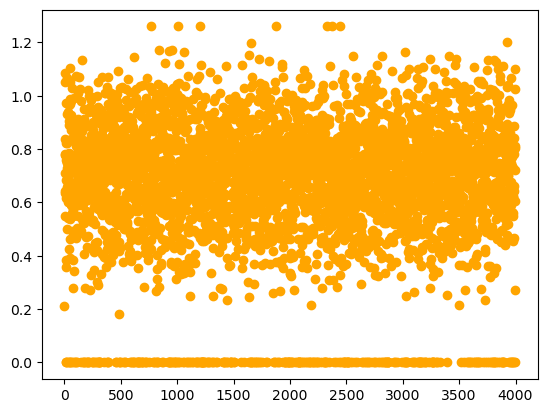

In [135]:


plt.scatter(np.arange(len(final_df['minkowski_distances'])), final_df['minkowski_distances'], color ='orange')

<AxesSubplot:title={'center':'MINKOWSKI DISTANCE SIMILARITIES'}, ylabel='Frequency'>

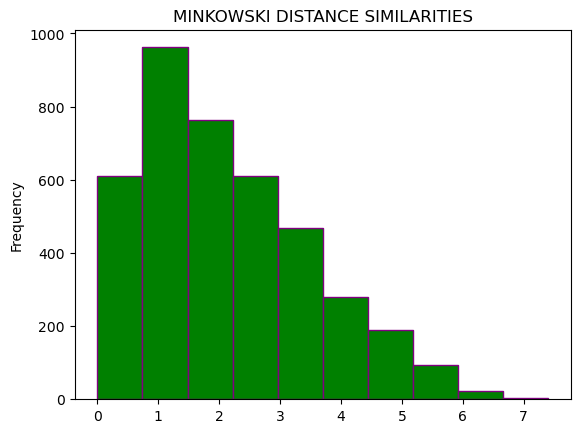

In [136]:
final_df['manhattan_distances'].plot(kind = 'hist',color='green', 
                                     edgecolor='purple' , title='MINKOWSKI DISTANCE SIMILARITIES')

<AxesSubplot:title={'center':'MINKOWSKI DISTANCE SIMILARITIES'}, ylabel='Frequency'>

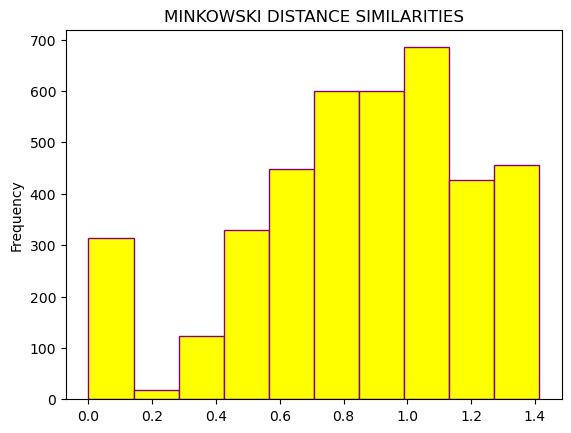

In [137]:
final_df['euclidean_distances'].plot(kind = 'hist',color='yellow', 
                                     edgecolor='purple' , title='MINKOWSKI DISTANCE SIMILARITIES')

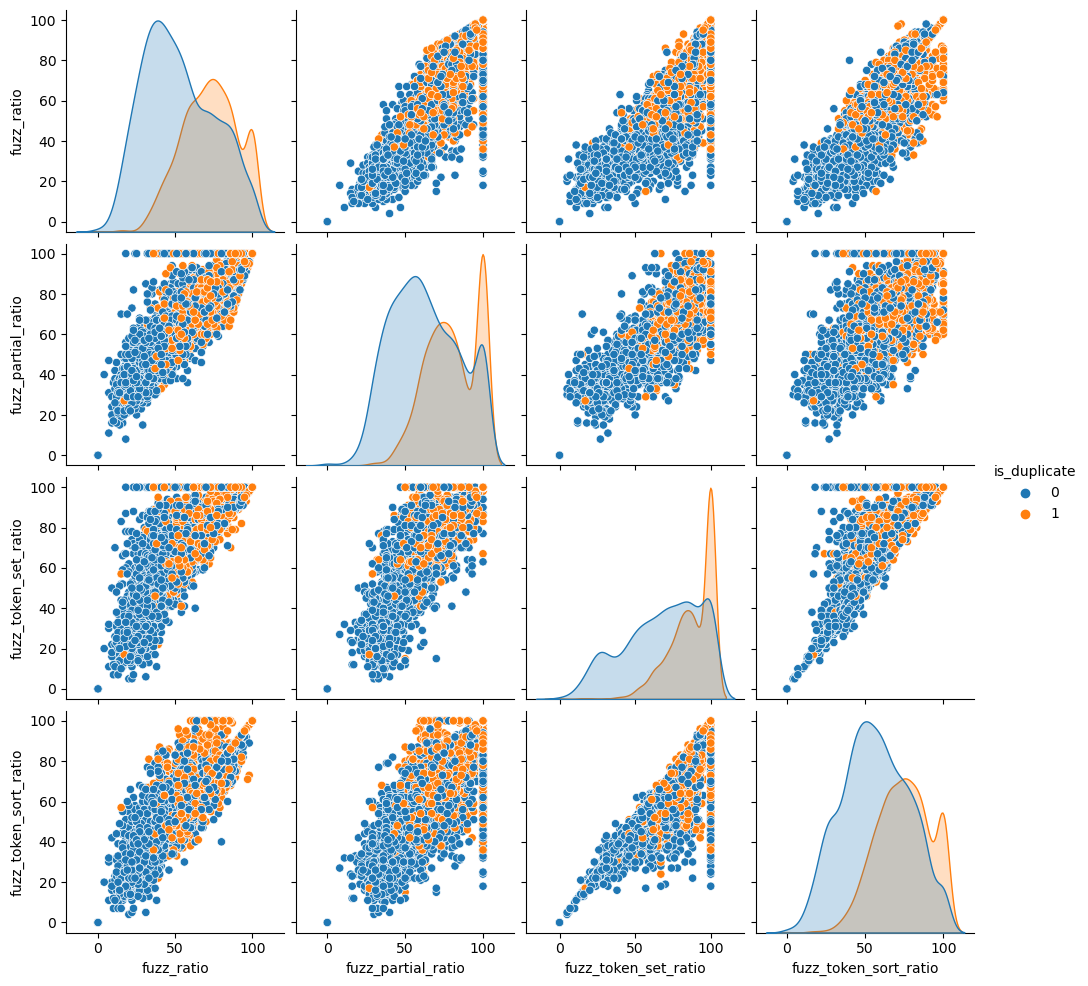

In [138]:
sns.pairplot(final_df[['fuzz_ratio','fuzz_partial_ratio','fuzz_token_set_ratio',
                       'fuzz_token_sort_ratio','is_duplicate']],hue='is_duplicate')

<AxesSubplot:title={'center':'MINKOWSKI DISTANCE SIMILARITIES'}, ylabel='Frequency'>

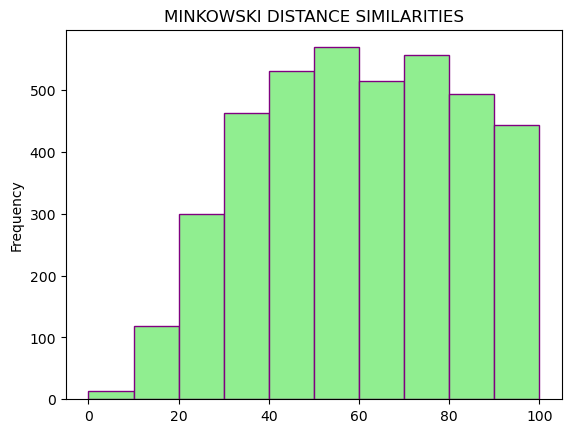

In [139]:
final_df['fuzz_ratio'].plot(kind = 'hist',color='lightgreen', 
                                     edgecolor='purple' , title='MINKOWSKI DISTANCE SIMILARITIES')

<AxesSubplot:title={'center':'MINKOWSKI DISTANCE SIMILARITIES'}, ylabel='Frequency'>

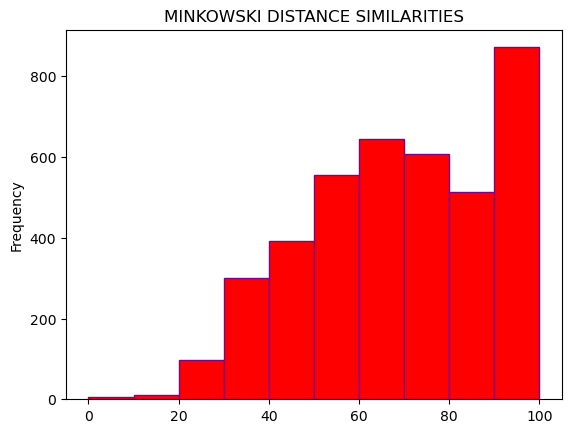

In [140]:
final_df['fuzz_partial_ratio'].plot(kind = 'hist',color='red', 
                                     edgecolor='purple' , title='MINKOWSKI DISTANCE SIMILARITIES')

<AxesSubplot:title={'center':'MINKOWSKI DISTANCE SIMILARITIES'}, ylabel='Frequency'>

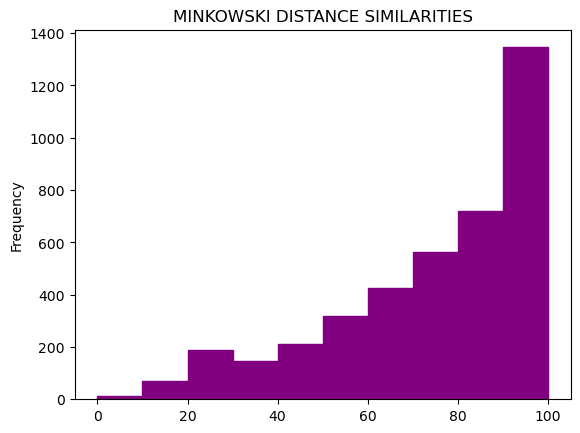

In [141]:
final_df['fuzz_token_set_ratio'].plot(kind = 'hist',color='purple', 
                                     edgecolor='purple' , title='MINKOWSKI DISTANCE SIMILARITIES')

<AxesSubplot:title={'center':'MINKOWSKI DISTANCE SIMILARITIES'}, ylabel='Frequency'>

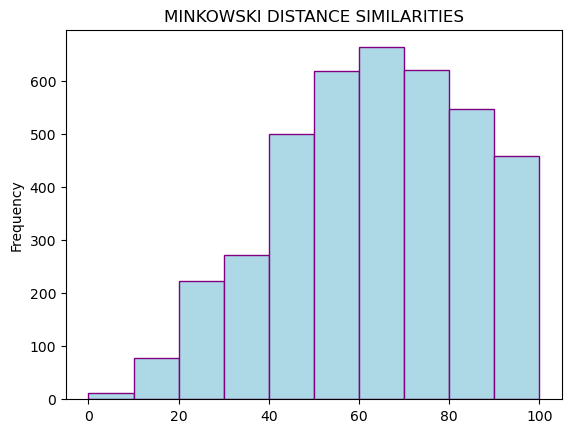

In [142]:
final_df['fuzz_token_sort_ratio'].plot(kind = 'hist',color='lightblue', 
                                     edgecolor='purple' , title='MINKOWSKI DISTANCE SIMILARITIES')

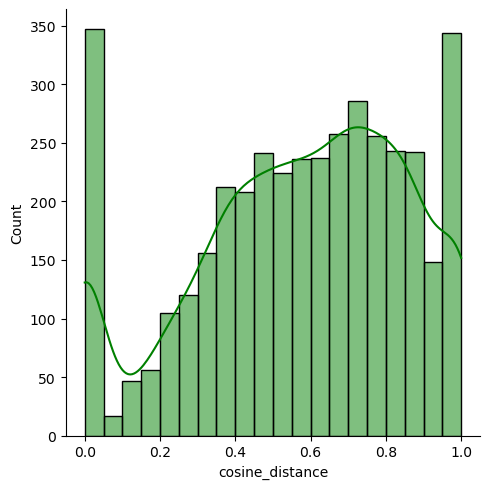

In [143]:
sns.displot(data=final_df, x="cosine_distance", kde=True, color='green')

C:\Users\Ashok\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ashok\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


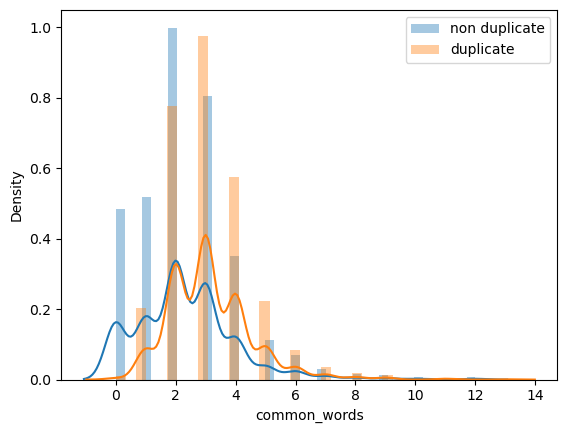

In [144]:
# common words
sns.distplot(final_df[final_df['is_duplicate'] == 0]['common_words'],label='non duplicate')
sns.distplot(final_df[final_df['is_duplicate'] == 1]['common_words'],label='duplicate')
plt.legend()
plt.show()

C:\Users\Ashok\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ashok\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


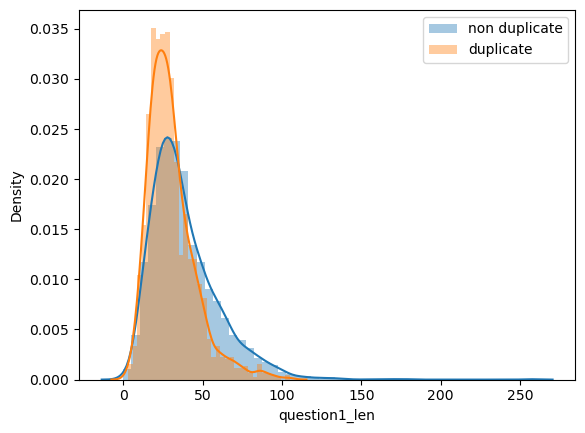

In [145]:
# common words
sns.distplot(final_df[final_df['is_duplicate'] == 0]['question1_len'],label='non duplicate')
sns.distplot(final_df[final_df['is_duplicate'] == 1]['question1_len'],label='duplicate')
plt.legend()
plt.show()

C:\Users\Ashok\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ashok\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


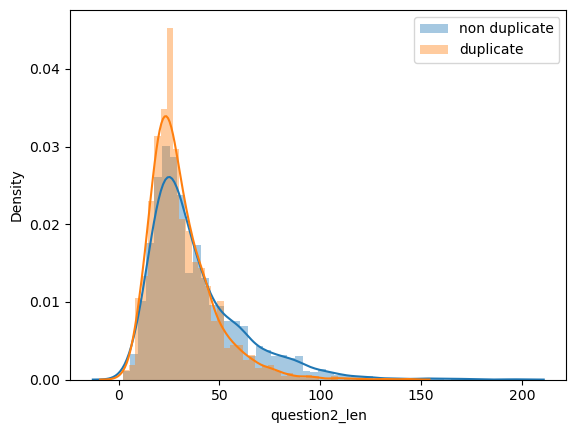

In [146]:
# common words
sns.distplot(final_df[final_df['is_duplicate'] == 0]['question2_len'],label='non duplicate')
sns.distplot(final_df[final_df['is_duplicate'] == 1]['question2_len'],label='duplicate')
plt.legend()
plt.show()

<AxesSubplot:xlabel='fuzz_ratio', ylabel='count'>

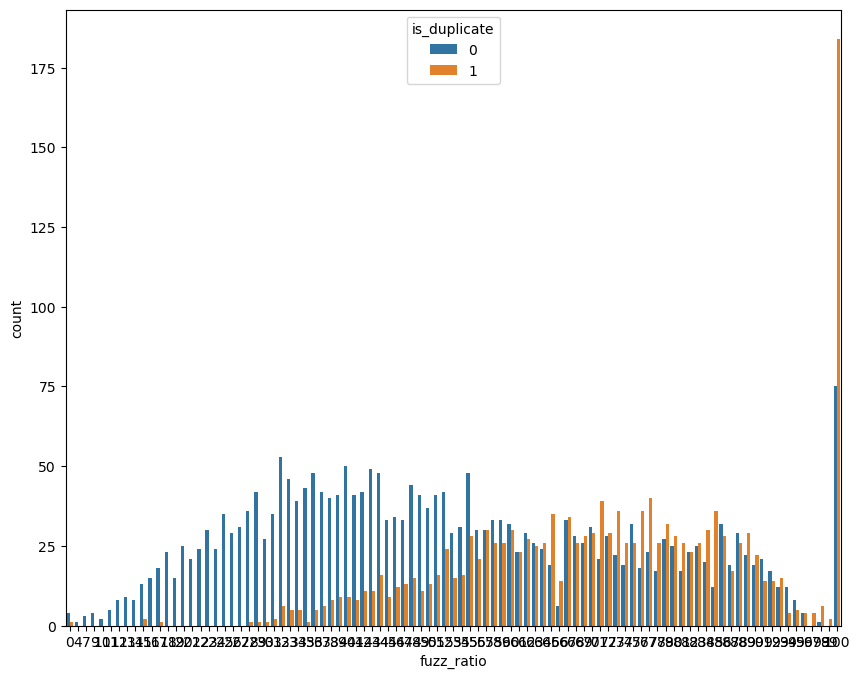

In [147]:
plt.figure(figsize=(10,8))
sns.countplot(data=final_df,x='fuzz_ratio',hue='is_duplicate')

<AxesSubplot:xlabel='common_words', ylabel='count'>

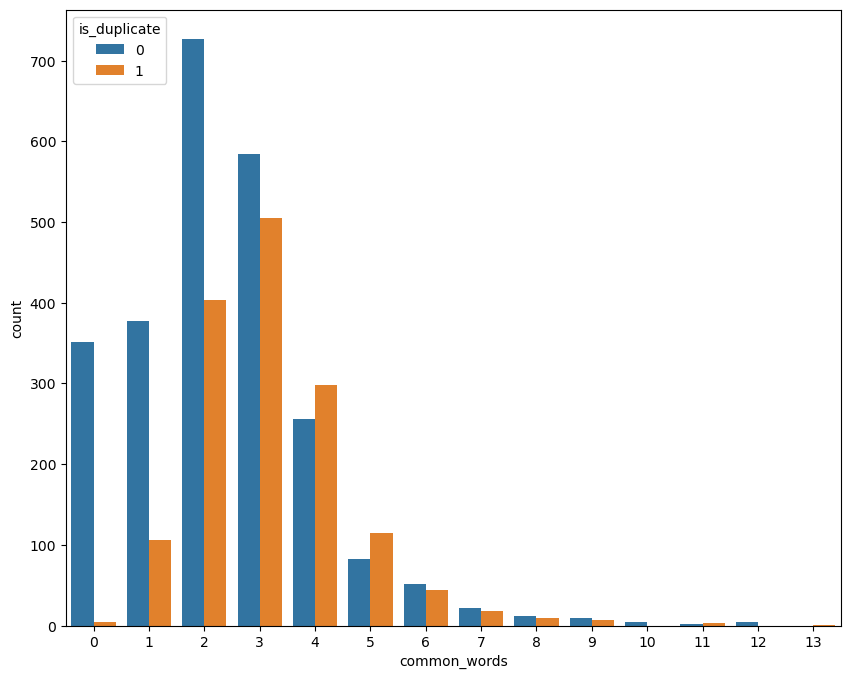

In [148]:
plt.figure(figsize=(10,8))
sns.countplot(data=final_df,x='common_words',hue='is_duplicate')

<AxesSubplot:xlabel='fuzz_partial_ratio', ylabel='count'>

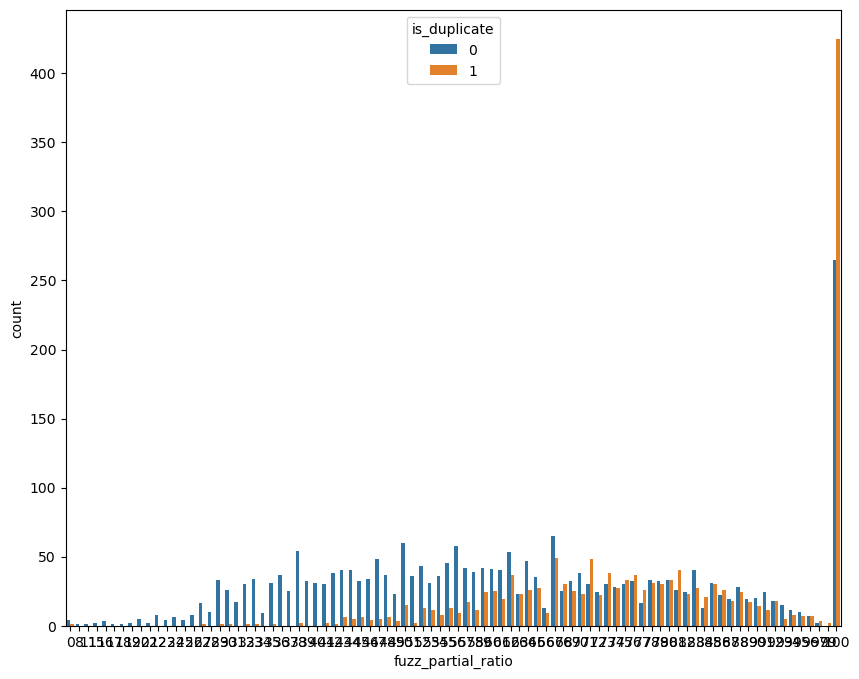

In [149]:
plt.figure(figsize=(10,8))
sns.countplot(data=final_df,x='fuzz_partial_ratio',hue='is_duplicate')

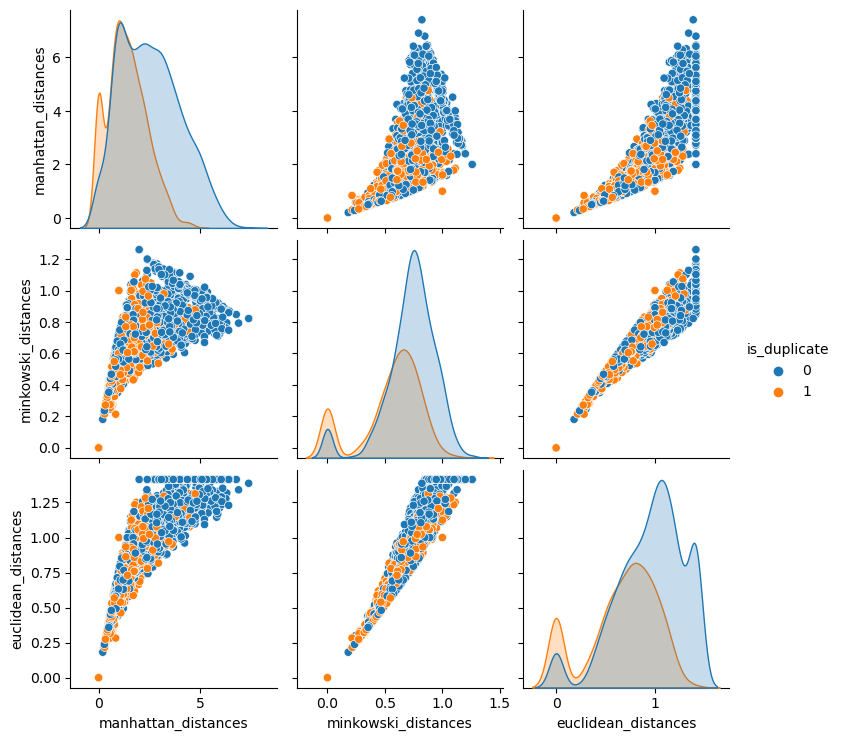

In [150]:
sns.pairplot(final_df[['manhattan_distances', 'minkowski_distances', 'euclidean_distances','is_duplicate']],hue='is_duplicate')

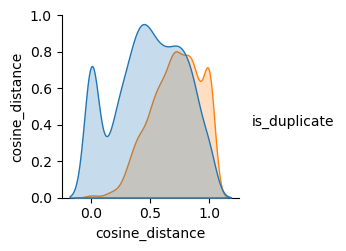

In [151]:
sns.pairplot(final_df[['cosine_distance','is_duplicate']],hue='is_duplicate')

# SAVING DATFRAME IN CSV FILE

In [152]:
final_df.to_csv('cleanquestions.csv', index = False)